<a href="https://colab.research.google.com/github/tsakailab/prml/blob/master/ipynb/ex_Trees_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 決定木とランダムフォレスト（decision trees and random forests）

----

氏名：

学生番号：

----
基本課題（必須）

    1. 「★scikit-learn を用いた決定木とランダムフォレスト」まで実行すると，どのような数値と図が出力されますか．また，
       特にExample 3とExample 4について，DecisionTreeClassifierのどの設定値が訓練データや検証データの正答率に影響しますか．
       理由と共に解説してください．

（ここに回答を書いてください）



    2. Example 3とExample 4について，ランダムフォレストによる識別の結果は決定木とどのように異なりますか．
       これらの例から，特にどのような性質をもつデータに対して，どのような設定でアンサンブル学習を適用すると，
       その効果を期待できると考えられますか．理由と共に述べてください．

（ここに回答を書いてください）



    3. DecisionTreeClassifierを用いてランダムフォレストを実装してください．

（回答はこのファイルの後半「★ランダムフォレストの実装」に書いてください）



    4.その他，気づいたこと，調べたことを書いてください．

（ここに回答を書いてください）



----
発展課題（任意）がこのノートブックの後半にあります．

In [ ]:
#@title [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)の基本的な使い方
from IPython.display import HTML, IFrame
IFrame("https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html", width=960, height=320)

In [ ]:
# データの用意
import numpy as np
from sklearn.datasets import load_wine
from  sklearn.model_selection import train_test_split

#The Wine Recognition database from UCI, to determine the origin of wines using chemical analysis
# https://archive.ics.uci.edu/ml/datasets/wine
dataset = load_wine()
X, X_val, y, y_val = train_test_split(dataset.data, dataset.target, test_size=0.30)#, random_state=0)


# 決定木
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=0)
model.fit(X, y)

print("Accuracy on training data: ", model.score(X, y))
print("Accuracy on validation data: ", model.score(X_val, y_val))
y_pred = model.predict(X_val)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plot_tree(model, filled=True, feature_names=dataset.feature_names, class_names=dataset.target_names,
          label='none', impurity=False, rounded=True, fontsize=8);

In [ ]:
#@title 混同行列（行：正解，列：予測）
from sklearn import metrics
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

cm = metrics.confusion_matrix(y_val, y_pred)
print(cm)

#print(cm.sum(axis=0)

--------

In [ ]:
#@title グラフを描くクラス `plot2cls` と，木を記述する `show_tree` を定義します（理解不要）．
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn
import warnings
warnings.filterwarnings("ignore")#, category=np.VisibleDeprecationWarning)

class plot2cls:
    def __init__(self, X_train, y_train, decision_function=None, X_val=None, y_val=None, dx=0.02, cmap=plt.cm.bwr, xlim=None, ylim=None, margin=0.5, levels={0.0:'-'}, colors='k', bins=None):
        self.data = {'train': {'X': X_train, 'y': y_train}, 'val': {'X':X_val, 'y': y_val}}
        self.clf = decision_function
        if X_val is not None:
            xlim = [X_val[:, 0].min(), X_val[:, 0].max()]
            ylim = [X_val[:, 1].min(), X_val[:, 1].max()]
        else:
            xlim = [float('inf'), - float('inf')]
            ylim = [float('inf'), - float('inf')]
        xlim[0] = min(xlim[0], X_train[:, 0].min()) - margin
        xlim[1] = max(xlim[1], X_train[:, 0].max()) + margin
        ylim[0] = min(ylim[0], X_train[:, 1].min()) - margin
        ylim[1] = max(ylim[1], X_train[:, 1].max()) + margin
        if bins is None:
            bins = len(y_train) // 4
        self.layout = {'dx': dx, 'cmap': cmap, 'xlim': xlim, 'ylim': ylim, 'levels': levels, 'colors': colors, 'bins': bins}


    def _data_layout(self, ax, bbox_to_anchor, loc):
        ax.set_xlim(self.layout['xlim'][0], self.layout['xlim'][1])
        ax.set_ylim(self.layout['ylim'][0], self.layout['ylim'][1])
        #plt.axis('tight')
        ax.set_xlabel('x1', fontsize=16)
        ax.set_ylabel('x2', fontsize=16)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_aspect('equal')
        #ax.legend(bbox_to_anchor=(1.5,1.0), loc="upper right", fontsize=16, frameon=True)
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True, ncol=2)
            ax.get_legend().legendHandles[2].set_color('k')
            ax.get_legend().legendHandles[3].set_color('k')
        plt.tight_layout()


    def _scatter(self, ax, X, y, c=['r', 'b'], marker=['s', 'o'], label=None, alpha=1):
        ax.scatter(X[y>0, 0], X[y>0, 1], c=c[0],  marker=marker[0], cmap=self.layout['cmap'], edgecolors='k', label=label+'(+)', alpha=alpha)
        ax.scatter(X[y<=0, 0], X[y<=0, 1], c=c[1], marker=marker[1], cmap=self.layout['cmap'], edgecolors='k', label=label+'(-)', alpha=alpha)


    def _put_data(self, ax, alpha):
        if self.clf is not None and self.layout['levels'] is not None:
            xx, yy = np.meshgrid(np.arange(self.layout['xlim'][0], self.layout['xlim'][1], self.layout['dx']), np.arange(self.layout['ylim'][0], self.layout['ylim'][1], self.layout['dx']))

            # Show prediction by color by assigning a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
            Z = self.clf(np.c_[xx.ravel(), yy.ravel()])
            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            norm = tsn(vmin=np.minimum(Z[:].min(),-1e-6), vcenter=0, vmax=np.maximum(Z[:].max(),1e-6))
            if self.layout['cmap'] is not None:
                ax.pcolor(xx, yy, Z, cmap=self.layout['cmap'], alpha=0.1, edgecolors=None, norm=norm)
            lvls = list(self.layout['levels'].keys())
            linestyles = list(self.layout['levels'].values())
            ax.contour(xx, yy, Z, levels=lvls, colors=self.layout['colors'], linestyles=linestyles, alpha=0.5)

        self._scatter(ax, self.data['train']['X'], self.data['train']['y'], label='train', alpha=alpha)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            self._scatter(ax, self.data['val']['X'], self.data['val']['y'], c=['k', 'k'], label='val', alpha=alpha*0.2)


    def plot_data(self, bbox_to_anchor=(1,0), loc="lower left"):
        ax = plt.figure(figsize=(8,8))
        ax = plt.axes()
        self._put_data(ax, alpha=1)
        self._data_layout(ax, bbox_to_anchor=bbox_to_anchor, loc=loc)


    def _hist_layout(self, ax, bbox_to_anchor, loc, xlabel):
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel("Frequency", fontsize=16)
        #ax.axis('tight')
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        #plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
        from matplotlib.ticker import FormatStrFormatter
        ax.yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
        #ax.set_aspect(1)
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True, ncol=2)
            #ax.legend(ncol=2)
        plt.tight_layout()


    def _make_hist(self, ax):
        if self.clf is None:
            return
        pred = self.clf(self.data['train']['X'])
        gt = self.data['train']['y']
        ax.hist( [ pred[gt>0], pred[gt<=0] ], bins=self.layout['bins'], histtype='stepfilled', density=False, alpha=0.5, color=['r', 'b'], label=['train(+)', 'train(-)'])
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            pred = self.clf(self.data['val']['X'])
            gt = self.data['val']['y']
            ax.hist( [ pred[gt>0], pred[gt<=0] ], bins=self.layout['bins'], histtype='stepfilled', density=False, alpha=0.3, color=['r', 'b'], label=['val(+)', 'val(-)'])


    def plot_hist(self, loc="lower left", bbox_to_anchor=(0,1), xlabel="$g(x)$"):
        ax = plt.figure(figsize=(6,6))
        ax = plt.axes()
        self._make_hist(ax)
        self._hist_layout(ax,bbox_to_anchor, loc, xlabel)


    def plot_clf(self, loc="lower left", bbox_to_anchor=(0,1), xlabel="$g(x)$"):
        if self.clf is None:
            return

        fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
        #fig, axes = plt.subplots(nrows=1, ncols=2)
        ax = axes[0]
        self._put_data(ax, alpha=1)
        self._data_layout(ax, bbox_to_anchor, loc)

        #fig.set_figwidth(12)
        #fig.set_figheight(8)
        ax = axes[1]
        self._make_hist(ax)
        self._hist_layout(ax, bbox_to_anchor, loc, xlabel)


def show_tree(model):
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    node_depth = np.zeros(shape=n_nodes,dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has the following tree structure:" % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            if feature[i] == 0:
                print("%snode=%s test node: go to node %s if x1 <= %.2f else to node %s." % (node_depth[i] * "\t", i, children_left[i], threshold[i], children_right[i] ))
            elif feature[i] == 1:
                print("%snode=%s test node: go to node %s if x2 <= %.2f else to node %s." % (node_depth[i] * "\t", i, children_left[i], threshold[i], children_right[i] ))
            else:
                print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to node %s." % (node_depth[i] * "\t", i, children_left[i], feature[i], threshold[i], children_right[i] ))

### 実験用のデータ（2次元，2クラス）を生成します．
- Example 1～4 からひとつ選んで実行してください．

In [ ]:
# Example 1: y = or(x1, x2)
X = np.array([[0, 0], [1,0], [0,1], [1,1]])
y = np.array([-1,1,1,1])

X_val = X + np.random.randn(4, 2) * 0.2
y_val = y.copy()

In [ ]:
# Example 2: draw npos and nneg points from the Gaussian distribution for each class
npos = 30
nneg = 30
np.random.seed(321)
X = np.r_[np.random.randn(npos, 2) + [3, 3], np.random.randn(nneg, 2)]
# [1,1,...,1,-1,-1,...,-1]
y = np.array([1] * npos + [-1] * nneg)

X_val = X + np.random.randn(X.shape[0], 2) * 1.0
y_val = y.copy()

In [ ]:
# Example 3: create moons using sklearn
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
y[y==0] = -1

X_val, y_val = make_moons(n_samples=100, noise=0.3, random_state=1)
y_val[y_val==0] = -1

In [ ]:
# Example 4: create circles using sklearn
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=150, noise=0.2, random_state=0, factor=0.3)
y[y==0] = -1

X_val, y_val = make_circles(n_samples=150, noise=0.2, random_state=1, factor=0.3)
y_val[y_val==0] = -1

In [ ]:
#@title データを表示します．
plot2cls(X, y, X_val=X_val, y_val=y_val).plot_data()

### ★scikit-learn を用いた決定木とランダムフォレスト

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_samples=30)#, min_samples_leaf=10)
model.fit(X, y)

print("Accuracy on training data: ", model.score(X, y))
print("Accuracy on validation data: ", model.score(X_val, y_val))

dec = lambda X: model.predict_proba(X)[:,1]*2-1
plot2cls(X, y, dec, X_val, y_val).plot_clf()

feature_names = ['$x_1$', '$x_2$']
class_names=['0', '1']
arts = plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names,
          label='none', impurity=False, rounded=True, fontsize=8);

from matplotlib.colors import to_rgb
for art, v in zip(arts, model.tree_.value):
    art.get_bbox_patch().set_facecolor(to_rgb(['#a0a0ff', '#ffa0a0'][np.argmax(v)]))

#show_tree(model)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
model = RandomForestClassifier(criterion='entropy', n_estimators=1300)
model.fit(X, y)

print("Accuracy on training data: ", model.score(X, y))
print("Accuracy on validation data: ", model.score(X_val, y_val))

dec = lambda X: model.predict_proba(X)[:,1]*2-1
plot2cls(X, y, dec, X_val, y_val).plot_clf(xlabel="$2p-1$")

## ランダムフォレスト

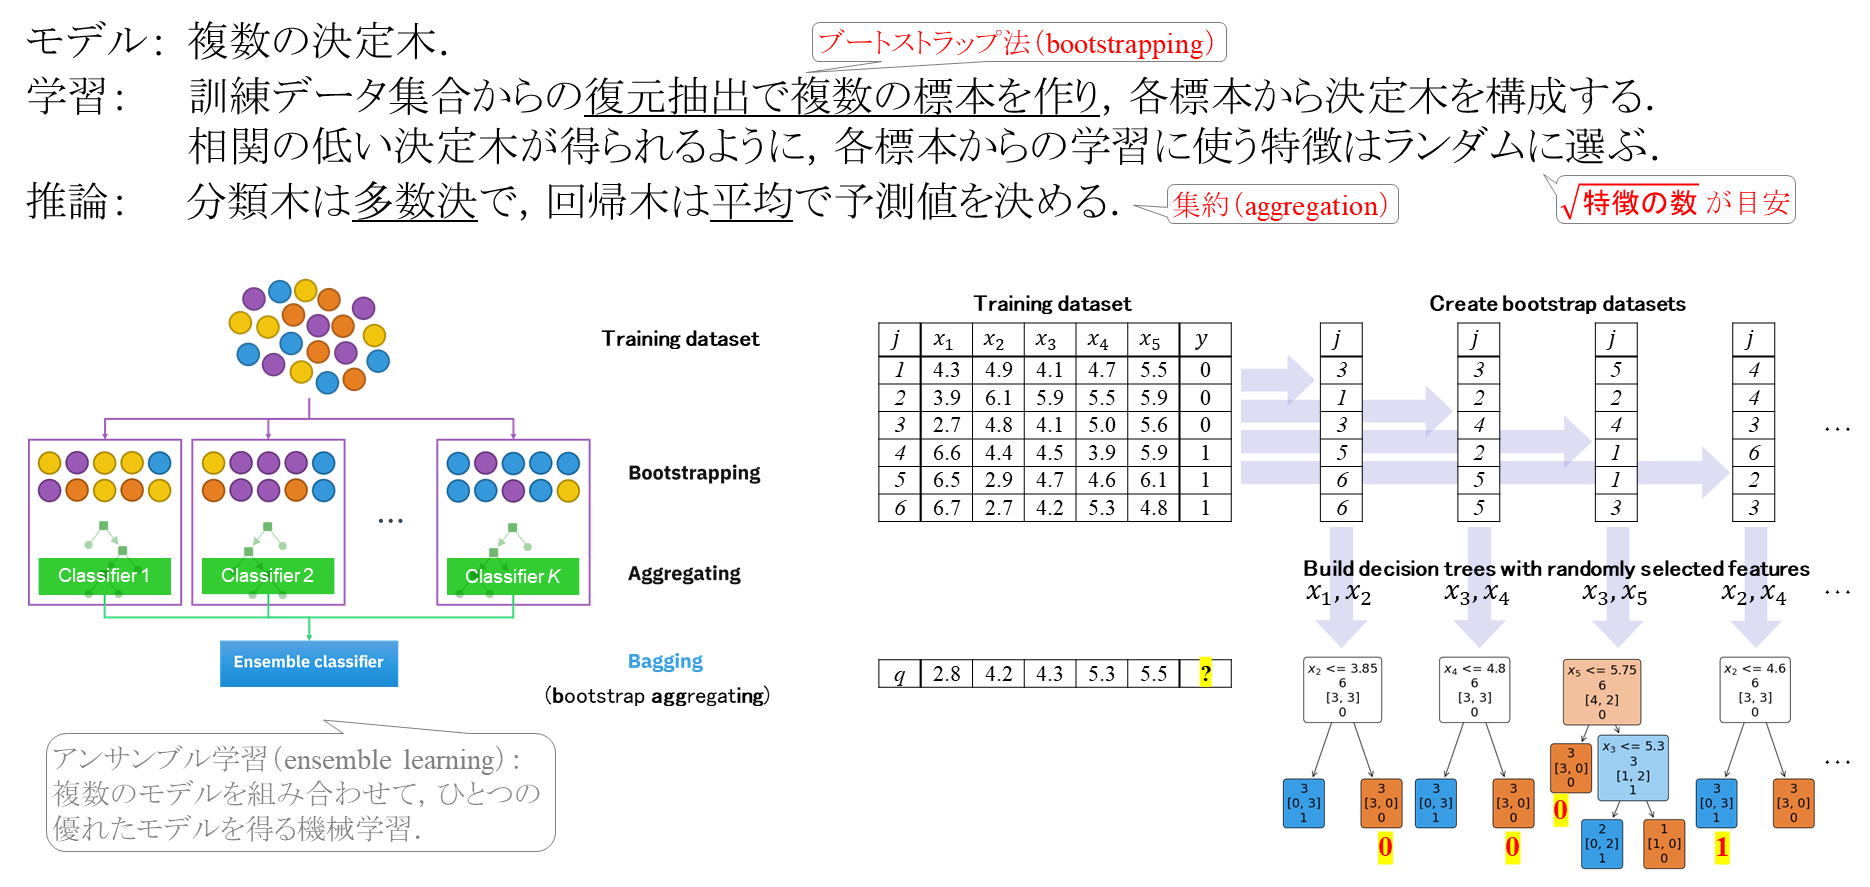

## ★ランダムフォレストの実装

sklearnの[`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)を用いて，`myRandomForestClassifier`という名のクラスとして実装しましょう．[sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) に似た仕様とします．

訓練データ `X_train` とクラスラベル `y_train` から `n_estimators` 個の決定木を作成したあと，`X_val` のクラスラベルの予測 `y_pred` や各クラスの得票率 `y_proba` を得たり，正答率を表示するには，
```
    myclf = myRandomForestClassifier(n_estimators=300, max_samples=None)
    myclf.fit(X_train, y_train)
    y_pred = myclf.predict(X_val)
    y_proba = myclf.predict_proba(X_val)
    print(myclf.score(X_val, y_val))
```
のように使うことを想定します．
- 訓練データの次元数`d`，個数`n`の場合，`X_train` と `y_train` はそれぞれ shape が `(n,d)` と `(n,)` のNumPy配列です．
- `myRandomForestClassifier` の引数 `n_estimators` は決定木の数，`max_samples` はブートストラップで復元抽出する際の訓練データの数です．`max_samples=None` は`max_samples=n` と同じとします．
- `myRandomForestClassifier` は，`n_estimators` と `max_samples` の他，[`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) に渡すための引数として `criterion='gini'`, `splitter='best'`, `max_depth=None`, ... などを指定できるように実装するとよいでしょう．

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier


# (X, y) から max_samples 個を復元抽出する関数です．
def bootstrap(X, y, max_samples):
    n_samples = X.shape[0]
    idxs = ''' np.random.choice を使い，整数 0～(n_samples-1) から max_samples 個を復元抽出する '''
    return X[idxs], y[idxs]


class myRandomForestClassifier:
    
    def __init__(self, n_estimators=100, max_samples=None, criterion='gini', splitter='best', max_depth=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.estimators = []
        self.classes = None


    # 学習：n_estimators 個の決定木を作ります．
    def fit(self, X, y):

        # クラスを表す整数のリスト
        self.classes = np.unique(y)

        b_samples = '''復元抽出する個数．max_samples が None ならば X.shape[0] 個全部． '''

        self.estimators = []
        for _ in range(self.n_estimators):
            Xb, yb = '''X と y から b_samples 個を bootstrap で復元抽出します． '''
            tree = '''決定木を用意します．criterion, splitter, max_depthなどを設定しましょう．'''
            tree.fit(Xb, yb)
            self.estimators.append(tree)


    # 推論：各クラスの得票率を答えます．
    def predict_proba(self, X):
        preds = np.array([clf.predict(X) for clf in self.estimators]).T       # (n, n_estimators)
        y_counts = [list(map(lambda c: len(y[y==c]), self.classes)) for y in preds]
        return np.array(y_counts) / self.n_estimators
        

    # 推論：最も多く得票したクラスを答えます．
    def predict(self, X):
        proba = self.predict_proba(X)       # (n,len(self.classes))
        y_pred =  ''' 得票率の最大値をもつクラスの番号を  proba から見つけます． '''
        y_pred = np.argmax(proba, axis=1)
        return self.classes[y_pred]


    def score(self, X, y):
        y_pred = self.predict(X)
        return (y == y_pred).sum() / len(y)

### 実装した`myRandomForest`で識別します．

In [ ]:
model = myRandomForestClassifier(n_estimators=100, max_samples=30)
model.fit(X, y)

print("Accuracy on training data: ", model.score(X, y))
print("Accuracy on validation data: ", model.score(X_val, y_val))

dec = lambda X: model.predict_proba(X)[:,1]*2-1
plot2cls(X, y, dec, X_val, y_val).plot_clf(xlabel="$2p-1$")

--------
## 発展課題（任意）

    1. 特徴の数（特徴空間の次元数）が大きい高次元データに対して，アンサンブル学習の効果を高める工夫を述べてください．  
       また，その効果を実験的に確認できるデータ集合を探してください．

（ここに回答を書いてください）


    2. 実装したランダムフォレストのDecisionTreeClassifierを別の識別器に差し替えてもアンサンブル学習ができます．
       どの識別器を，どのような設定値で使用すると，アンサンブル学習の効果が得られますか．

（ここに回答を書いてください）

お疲れさまでした．